In [2]:
from datacleanv2 import *
from SetRNN import *
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence, pad_packed_sequence
from collections import Counter # 用于统计计数的工具
import time # 用于计时
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils # 用于处理变长序列，如填充和打包
from torch.utils.data import Dataset, DataLoader # PyTorch 数据加载工具
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm # 进度条库，使用 tqdm.tqdm
import random
import pyreadstat
import copy # 用于复制模型参数或列表
import matplotlib.pyplot as plt # 用于绘图
import seaborn as sns # 用于更美观的统计图，特别是热力图
import pickle
plt.rcParams['font.family'] = ['SimHei'] # 使用黑体，或其他支持中文的字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题


In [2]:
#读取数据
df,mata = pyreadstat.read_sav(r"E:\复旦大学\研一上\科研\评分剪枝算法\数据\data\CBA_cp025q01_logs12_SPSS.sav")


In [6]:

final_result_list_raw=create_time_series_with_result(remove_consecutive_duplicates(transform_sub_dfs(split_strict_paired_events(df))))
#final_result_list = random.sample(final_result_list_raw, 10000)
transformed_list_mix = transform_setting_data_handle_categorical_input(final_result_list_raw)
transformed_list=[item for item in transformed_list_mix if len(item[0])>=3]#去除过短的序列


In [ ]:
transformed_list

[[   time combined_setting
  2  50.3               93
  3  58.7               94
  4  62.0               99
  5  66.4              124
  6  73.0              118,
  "'100101"],
 [    time combined_setting
  31  49.1               24
  32  51.9               20
  33  55.0                0
  34  57.2              100
  35  59.5              120
  36  61.5              124
  37  69.6               83
  38  75.6               41
  39  79.5               31
  40  86.2               93,
  "'000000"],
 [      time combined_setting
  57    68.5               62
  80    88.6               83
  97   100.0               62
  114  107.1               72
  136  113.6               70
  147  120.7               20
  174  191.0               62
  179  196.2               60
  198  218.2               52
  217  235.7               74,
  "'100101"],
 [     time combined_setting
  384  19.6               62
  404  40.0              107
  406  42.3               62
  415  61.6              108,
  "'10010

In [ ]:
df_response = pd.read_csv(r"E:\复旦大学\研一上\科研\评分剪枝算法\数据\traffic\traffic_q2_response.csv")
df_seq = pd.read_csv(r"E:\复旦大学\研一上\科研\评分剪枝算法\数据\traffic\traffic_q2_seq.csv")


In [4]:
# 1. 将action的列名改为combined_setting
df_seq = df_seq.rename(columns={'action': 'combined_setting'})
df_seq["combined_setting"] = df_seq["combined_setting"] - 1  # 假设原始数据是从1开始的，这里将其转换为从0开始
# 2. 将数据框切割，连续的ID相同的行被切割进同一个数据框
# 创建分组标识：当ID发生变化时开始新分组

# 按分组切割数据框并组成列表
grouped_dfs = [group for _, group in df_seq.groupby('ID')]

print(f"切割后得到 {len(grouped_dfs)} 个数据框")

# 3. 去除每个数据框元素的第一行和最后一行
# 4. 去除所有长度小于3的数据框（去除后长度至少为1）
filtered_dfs = []

for i, df_group in enumerate(grouped_dfs):
    # 如果数据框长度大于等于3，才进行处理
    if len(df_group) >= 5:
        # 去除第一行和最后一行
        trimmed_df = df_group.iloc[1:-1].copy()
      
        matching_row = df_response[df_response['ID'] == trimmed_df['ID'].iloc[0]]
        response_value = matching_row['Response'].iloc[0] 
        trimmed_df = trimmed_df.drop(columns=['ID'])
        filtered_dfs.append([trimmed_df, response_value])  # 假设 df_response 的索引与 grouped_dfs 对应


切割后得到 31656 个数据框


In [5]:
filtered_dfs

[[     combined_setting   time
  9                  20   25.9
  10                 13   27.3
  11                 22   28.4
  12                 22   28.9
  13                 13   30.9
  ..                ...    ...
  199                21  257.3
  200                 9  263.5
  201                 7  264.3
  202                 8  265.1
  203                19  266.3
  
  [195 rows x 2 columns],
  np.int64(1)],
 [     combined_setting   time
  216                 9   75.9
  217                 7   77.1
  218                 8   78.1
  219                 8   81.3
  220                16   82.5
  ..                ...    ...
  288                20  223.9
  289                 7  226.1
  290                 7  227.3
  291                 4  227.9
  292                 9  229.5
  
  [77 rows x 2 columns],
  np.int64(0)],
 [     combined_setting  time
  299                 9  27.7
  300                 7  28.6
  301                 8  29.4
  302                19  30.5
  303            

In [9]:
[max(set(item[0]['combined_setting']) for item in filtered_dfs)]

[{0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22}]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EARLY_ITER_BATCH_THRESHOLD = 3 # 在前 3 轮迭代中使用部分批次 (适应总迭代 10)
EARLY_ITER_BATCH_PERCENT = 0.3

# 超参数和常量定义
NUM_MAIN_MODELS = 3 # 主要的聚类模型数量
NUM_COMBINED_SETTINGS = 23 # combined_setting 的总类别数 (0-22)
EMBEDDING_DIM = 8 # combined_setting 的嵌入向量维度，可调整
HIDDEN_SIZE = 64   # RNN 隐藏层大小，可调整
NUM_RNN_LAYERS = 2 # RNN 层数
# 注意: TIME_LOSS_SCALER 可能需要根据实际 delta_t 的规模重新调整
TIME_LOSS_SCALER = 1 # time delta_t MSE 损失的缩放因子，需要根据实际损失值大小调整

TOTAL_EM_ITERATIONS = 10 # EM 迭代总次数 (根据要求修改为 10)
CONVERGENCE_THRESHOLD = 0.05 # 收敛阈值，分配改变的序列比例低于此值时停止 (5%)

# 干扰项处理参数
NUM_RAND_SEQUENCES = 250 # 干扰项的已知数量
INTERFERENCE_CLUSTER_LABEL = 3 # 将干扰项分配到的簇的索引 (0, 1, 2 是主簇，3 是干扰簇)
INTERFERENCE_DETECTION_START_ITER = 2 # 从第 5 轮迭代 (索引 4) 的 E 步开始检测干扰项
# 检测干扰项的高损失阈值：需要根据训练中观察到的损失值范围来调整
# 如果一个序列在所有模型上的平均损失超过这个阈值，则可能被认为是干扰项。
# ！！！重要参数，需要根据实际运行观察的损失值调整！！！
# 在模拟数据上运行一次，观察损失值的分布，尤其是 rand_label 序列的损失。
HIGH_AVG_LOSS_THRESHOLD = 0.5 ## <--- !!! 初始值，请务必根据实际情况调整 !!!

# M 步训练参数 (每个 EM 迭代中的训练 epochs)
# epochs 计划表：根据迭代次数使用不同数量的 epochs
EPOCH_SCHEDULE = [1] * 5 + [2]* 5 # 示例：前 3 轮迭代训练 2 epoch，接下来 7 轮训练 5 epoch (适应总迭代 10)
BATCH_SIZE = 32 # M 步训练时的批次大小
# 在早期迭代中是否只使用部分批次来加速训练
EARLY_ITER_BATCH_THRESHOLD = 3 # 在前 3 轮迭代中使用部分批次 (适应总迭代 10)
EARLY_ITER_BATCH_PERCENT = 0.3 # 在启用部分批次训练时使用的批次比例 (30%)

In [12]:
# 函数声明

class SettingPredictorRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_size, num_rnn_layers, num_categories):
        super(SettingPredictorRNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_rnn_layers = num_rnn_layers
        self.num_categories = num_categories

        # 输入是 当前时间差 delta_t (1维) 和 combined_setting 的嵌入向量 (embedding_dim 维)
        # 模型会根据当前时间差、设置和历史预测下一个时间步的时间差和设置
        self.setting_embedding = nn.Embedding(num_categories, embedding_dim)
        input_size = 1 + embedding_dim

        # 使用 GRU 作为 RNN 层
        self.rnn = nn.GRU(input_size, hidden_size, num_rnn_layers, batch_first=True)

        # 输出层
        # 预测下一个时间步的时间差 delta_t (回归问题，输出 1维)
        self.time_delta_output = nn.Linear(hidden_size, 1)
        # 预测下一个 combined_setting (分类问题，输出 num_categories 维的 logits)
        self.setting_output = nn.Linear(hidden_size, num_categories)

    # 前向传播，处理填充后的批次序列
    def forward(self, time_delta_seq, setting_seq, lengths, hidden_state=None):
        # time_delta_seq 形状: (batch_size, seq_len) - 填充后的 当前时间差 序列
        # setting_seq 形状: (batch_size, seq_len) - 填充后的 当前 setting 整数索引序列 (long tensor)
        # lengths: 原始输入序列长度的列表或 tensor (对应 time_delta_seq 和 setting_seq 的长度)

        # 将 setting 整数索引转换为嵌入向量
        setting_embedded = self.setting_embedding(setting_seq) # 形状: (batch_size, seq_len, embedding_dim)

        # 组合当前时间差输入和嵌入后的 setting
        input_seq = torch.cat((time_delta_seq.unsqueeze(-1), setting_embedded), dim=-1) # 形状: (batch_size, seq_len, 1 + embedding_dim)

        # 打包填充后的序列
        # lengths 必须在 CPU 上
        packed_input = rnn_utils.pack_padded_sequence(input_seq, lengths.cpu(), batch_first=True, enforce_sorted=False)

        # 通过 RNN 层
        packed_output, hidden_state = self.rnn(packed_input, hidden_state)

        # 将打包的序列重新填充回原始形状
        output_seq, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True, total_length=input_seq.size(1)) # 形状: (batch_size, seq_len, hidden_size)

        # 通过输出层进行预测
        # 预测的是下一个时间步的 delta_t (即输入序列中当前步对应的下一个 delta_t)
        predicted_next_delta_t = self.time_delta_output(output_seq) # 形状: (batch_size, seq_len, 1)
        # 预测的是下一个 setting 的 logits (即输入序列中当前步对应的下一个 setting)
        predicted_next_setting_logits = self.setting_output(output_seq) # 形状: (batch_size, seq_len, num_categories)

        # 压缩 predicted_next_delta_t 的最后一维
        predicted_next_delta_t = predicted_next_delta_t.squeeze(-1) # 形状: (batch_size, seq_len)

        return predicted_next_delta_t, predicted_next_setting_logits, hidden_state

# ----------------------------------------------------------------------------
# 2. 准备数据加载器 SequenceDataset 和 Collate Function (在 collate_fn 中计算 delta_t 输入和目标)
# ----------------------------------------------------------------------------

class SequenceDataset(Dataset):
    def __init__(self, data_list):
        """
        自定义数据集类。
        Args:
            data_list: DataFrame 列表，每个 DataFrame 代表一个序列。
                       DataFrame 应包含 'time' (float) 和
                       'combined_setting' (类别类型，类别为 0-124 的整数) 列。
                       注意：time 到 delta_t 的转换在 collate_fn 中完成。
        """
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        df = self.data_list[idx]
        # 将整个 'time' 和 'combined_setting' 序列返回
        time_seq = torch.FloatTensor(df['time'].values)
        setting_seq = torch.LongTensor(df['combined_setting'].astype(int).values) # 确保是 LongTensor 用于 embedding

        # 返回完整序列数据和原始长度
        return time_seq, setting_seq, len(df)

# 批处理数据的 Collate Function
def collate_fn(batch):
    # batch 是一个元组列表：[(time_seq_1, setting_seq_1, len_1), ...]

    # 根据原始序列长度降序排序批次
    batch.sort(key=lambda x: x[2], reverse=True)

    # 解压批次数据
    time_seqs_list, setting_seqs_list, original_lengths = zip(*batch)

    # 过滤掉原始长度小于 3 的序列，这些序列无法构建有效的输入和目标序列 (长度 original_length - 2)
    valid_indices = [i for i, length in enumerate(original_lengths) if length >= 3]

    if not valid_indices:
        # 如果批次中没有长度 >= 3 的序列，返回 None 表示空批次
        return None

    # 提取有效的序列和长度
    time_seqs_list = [time_seqs_list[i] for i in valid_indices]
    setting_seqs_list = [setting_seqs_list[i] for i in valid_indices]
    valid_original_lengths = [original_lengths[i] for i in valid_indices]


    # --- 计算输入序列 (当前 delta_t 和 setting) 和目标序列 (下一个 delta_t 和 setting) ---
    # 它们都对应原始序列长度 - 2 的部分

    # delta_t 输入: time[i+1] - time[i] for i from 0 to original_length - 3
    delta_t_inputs_list = [(seq[1:-1] - seq[:-2]) for seq in time_seqs_list]
    # setting 输入: setting[i] for i from 0 to original_length - 3
    setting_inputs_list = [seq[:-2] for seq in setting_seqs_list]

    # delta_t 目标: time[i+2] - time[i+1] for i from 0 to original_length - 3
    delta_t_targets_list = [(seq[2:] - seq[1:-1]) for seq in time_seqs_list]
    # setting 目标: setting[i+1] for i from 0 to original_length - 3
    setting_targets_list = [seq[1:-1] for seq in setting_seqs_list]


    # 输入/目标序列的长度都等于 original_length - 2
    input_lengths = [length - 2 for length in valid_original_lengths]


    # 填充输入序列
    delta_t_inputs_padded = rnn_utils.pad_sequence(delta_t_inputs_list, batch_first=True, padding_value=0.0)
    setting_inputs_padded = rnn_utils.pad_sequence(setting_inputs_list, batch_first=True, padding_value=0)

    # 填充目标序列
    delta_t_targets_padded = rnn_utils.pad_sequence(delta_t_targets_list, batch_first=True, padding_value=0.0)
    setting_targets_padded = rnn_utils.pad_sequence(setting_targets_list, batch_first=True, padding_value=0)


    # 输入序列的有效长度
    input_lengths_tensor = torch.LongTensor(input_lengths)

    # 根据输入序列的有效长度重新排序批次
    sorted_lengths, sorted_indices = torch.sort(input_lengths_tensor, descending=True)

    # 按照 sorted_indices 对所有张量进行排序
    delta_t_inputs_padded = delta_t_inputs_padded[sorted_indices]
    setting_inputs_padded = setting_inputs_padded[sorted_indices]
    delta_t_targets_padded = delta_t_targets_padded[sorted_indices]
    setting_targets_padded = setting_targets_padded[sorted_indices]

    # 将张量移动到设备
    delta_t_inputs_padded = delta_t_inputs_padded.to(device)
    setting_inputs_padded = setting_inputs_padded.to(device)
    delta_t_targets_padded = delta_t_targets_padded.to(device)
    setting_targets_padded = setting_targets_padded.to(device)
    # sorted_lengths 保持在 CPU

    # 返回 delta_t 输入, setting 输入, delta_t 目标, setting 目标, 输入长度
    return delta_t_inputs_padded, setting_inputs_padded, delta_t_targets_padded, setting_targets_padded, sorted_lengths

# ----------------------------------------------------------------------------
# 3. 实现训练函数 train_model (使用 delta_t 目标计算时间预测损失)
#    接收模型索引作为参数进行打印。
# ----------------------------------------------------------------------------


def train_model(model, model_idx, dataloader, optimizer, time_criterion, setting_criterion, epochs, time_scaler, iteration_num):
    model.train() # 设置模型为训练模式
    total_batches = len(dataloader)
    # 根据迭代次数决定使用的批次数量
    if iteration_num < EARLY_ITER_BATCH_THRESHOLD:
        batches_to_use = max(1, int(total_batches * EARLY_ITER_BATCH_PERCENT))
    else:
        batches_to_use = total_batches

    # 使用 tqdm 显示 epoch 进度，使用传入的 model_idx
    epoch_tqdm = tqdm(range(epochs), desc=f"迭代 {iteration_num} (模型 {model_idx}) 训练", leave=False)
    for epoch in epoch_tqdm:
        batch_count = 0
        # 使用 tqdm 显示批次进度
        batch_tqdm = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for batch_data in batch_tqdm:
            if batch_data is None: continue # 跳过空批次

            # 从 collate_fn 获取批次数据
            # 获取的是 delta_t 输入
            delta_t_inputs, setting_inputs, delta_t_targets, setting_targets, lengths = batch_data

            optimizer.zero_grad() # 清零梯度

            # 前向传播
            # 模型现在输出的是 predicted_next_delta_t 和 predicted_next_setting_logits
            predicted_next_delta_t, predicted_next_setting_logits, _ = model(delta_t_inputs, setting_inputs, lengths)

            # 计算损失
            # predicted_next_delta_t 形状: (batch_size, seq_len)
            # delta_t_targets 形状: (batch_size, seq_len)
            time_loss = time_criterion(predicted_next_delta_t, delta_t_targets)

            # predicted_next_setting_logits 形状: (batch_size, seq_len, num_categories)
            # setting_targets 形状: (batch_size, seq_len)
            # 需要调整 logits 的维度到 (batch_size, num_categories, seq_len)
            setting_loss = setting_criterion(predicted_next_setting_logits.permute(0, 2, 1), setting_targets)

            # 计算总损失，并应用时间损失缩放因子
            loss = time_loss * time_scaler + setting_loss

            # 反向传播和优化
            loss.backward()
            # 可选：梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            batch_count += 1
            # 在早期迭代中，只训练部分批次
            if batch_count >= batches_to_use:
                 break

            # 更新批次进度条的后缀信息（可选）
            batch_tqdm.set_postfix(loss=loss.item())

        # 更新 epoch 进度条的后缀信息（可选）
        # 注意：这里显示的是最后一个批次的损失，不是平均损失
        epoch_tqdm.set_postfix(last_batch_loss=loss.item())

# ----------------------------------------------------------------------------
# 4. 实现评估函数 evaluate_sequence_loss (计算单个序列 **平均** 损失)
# ----------------------------------------------------------------------------

def evaluate_sequence_loss(model, time_seq_full, setting_seq_full, time_criterion, setting_criterion, time_scaler):
    model.eval() # 设置模型为评估模式
    with torch.no_grad(): # 禁用梯度计算

        seq_len = time_seq_full.size(0)
        # 序列长度小于 3 无法构建输入和目标序列 (长度 original_length - 2)
        if seq_len < 3:
            # 返回无穷大，表示无法计算有效损失，在比较时会被排除
            return float('inf')

        # --- 构建输入序列 (当前 delta_t 和 setting) 和目标序列 (下一个 delta_t 和 setting) ---
        # 它们都对应原始序列长度 - 2 的部分

        # delta_t 输入: time[i+1] - time[i] for i from 0 to seq_len - 3
        delta_t_inputs_sliced = (time_seq_full[1:-1] - time_seq_full[:-2]).unsqueeze(0).to(device) # 形状: (1, seq_len - 2)
        # setting 输入: setting[i] for i from 0 to seq_len - 3
        setting_inputs_sliced = setting_seq_full[:-2].unsqueeze(0).to(device) # 形状: (1, seq_len - 2)

        # delta_t 目标: time[i+2] - time[i+1] for i from 0 to seq_len - 3
        delta_t_targets_sliced = (time_seq_full[2:] - time_seq_full[1:-1]).unsqueeze(0).to(device) # 形状: (1, seq_len - 2)
        # setting 目标: setting[i+1] for i from 0 to seq_len - 3
        setting_targets_sliced = setting_seq_full[1:-1].unsqueeze(0).to(device) # 形状: (1, seq_len - 2)

        # 输入序列的实际长度
        eval_input_len = seq_len - 2 # 有效的预测步数
        lengths = torch.tensor([eval_input_len]) # 保持在 CPU

        # 前向传播，计算整个序列的预测结果 (长度为 eval_input_len)
        predicted_next_delta_t, predicted_next_setting_logits, _ = model(delta_t_inputs_sliced, setting_inputs_sliced, lengths)

        # 计算整个序列的损失 (注意：损失函数如 MSELoss 和 CrossEntropyLoss 默认计算的是批次和序列长度上的平均)
        # 但在这里我们处理的是单个序列 (batch_size = 1)，并且使用了 pack_padded_sequence，
        # PyTorch 会确保损失计算只在有效长度上进行。
        # 所以 time_criterion(predicted_next_delta_t, delta_t_targets_sliced) 计算的是 batch 和 有效长度上的平均损失。
        # setting_criterion(...) 也类似。

        time_loss = time_criterion(predicted_next_delta_t, delta_t_targets_sliced)
        setting_loss = setting_criterion(predicted_next_setting_logits.permute(0, 2, 1), setting_targets_sliced)

        # 计算总损失 (按步加权平均)
        total_loss_per_step = time_loss * time_scaler + setting_loss

        # total_loss_per_step 现在已经是每个预测步的平均损失了 (因为 MSELoss/CrossEntropyLoss 默认对 batch 和序列长度取平均)
        # 但是 pack_padded_sequence 的行为可能会影响这个平均，为了安全和明确，我们还是按总损失再除以步数
        # 更稳妥的方法是使用 reduction='sum' 然后手动除以有效步数
        time_criterion_sum = nn.MSELoss(reduction='sum')
        setting_criterion_sum = nn.CrossEntropyLoss(reduction='sum')

        time_loss_sum = time_criterion_sum(predicted_next_delta_t, delta_t_targets_sliced)
        setting_loss_sum = setting_criterion_sum(predicted_next_setting_logits.permute(0, 2, 1), setting_targets_sliced)

        total_sum_loss = time_loss_sum * time_scaler + setting_loss_sum
    
        # 计算 **平均** 损失：总和损失除以有效预测步数
        average_loss_per_step = total_sum_loss / eval_input_len
        average_set_loss_per_step = setting_loss_sum / eval_input_len


        # 返回标量平均损失值
        return average_loss_per_step.item(),average_set_loss_per_step.item()
# ----------------------------------------------------------------------------
# 5. 实现 EM-like 聚类算法 run_rnn_clustering (加入干扰项处理)
# ----------------------------------------------------------------------------

def run_rnn_clustering(transformed_list, num_main_models, embedding_dim, hidden_size, num_rnn_layers,
                       num_categories, time_scaler, total_iterations, convergence_threshold,
                       epoch_schedule, batch_size, early_iter_batch_threshold, early_iter_batch_percent,
                       interference_cluster_label, interference_detection_start_iter, high_avg_loss_threshold, num_rand_sequences):

    total_sequences = len(transformed_list)
    print(f"开始基于 RNN 的聚类，共有 {total_sequences} 条序列，聚成 {num_main_models} 类 + 1 干扰类 ({interference_cluster_label})。")

    # 1. 初始化
    # 创建 NUM_MAIN_MODELS 个结构相同的 RNN 模型
    models = [SettingPredictorRNN(embedding_dim, hidden_size, num_rnn_layers, num_categories).to(device) for _ in range(num_main_models)]

    # current_assignments: 存储当前迭代中用于 M 步训练和 E 步重新分配的簇分配 (0, 1, 2, 或 interference_cluster_label)。
    # 初始化时，所有序列随机分配到主簇。长度不足 3 的序列暂时分配到 -1。
    current_assignments = np.full(total_sequences, -1, dtype=int) # 初始化为 -1
    # 先将长度 >= 3 的序列随机分配到主簇
    long_enough_indices = np.where(np.array([len(item[0]) for item in transformed_list]) >= 3)[0]
    current_assignments[long_enough_indices] = np.random.randint(0, num_main_models, len(long_enough_indices))


    print(f"初始随机分配到主簇 (长度>=3 的序列): {np.bincount(current_assignments[current_assignments != -1], minlength=num_main_models)}")
    print(f"初始未分配序列 (长度<3): {np.sum(current_assignments == -1)}")


    # 定义损失函数 (用于 E 步计算单序列损失，使用 reduction='sum')
    time_criterion_sum = nn.MSELoss(reduction='sum')
    setting_criterion_sum = nn.CrossEntropyLoss(reduction='sum')
    # 定义损失函数 (用于 M 步训练批次，使用默认 reduction='mean')
    time_criterion_mean = nn.MSELoss()
    setting_criterion_mean = nn.CrossEntropyLoss()


    # 记录被标记为干扰项的序列的原始索引 (仅用于跟踪和最终返回)
    removed_interference_indices_tracker = []

    # 2. EM-like 迭代循环
    main_tqdm = tqdm(range(total_iterations), desc="EM 迭代总进度")
    for iter_num in main_tqdm:
        main_tqdm.set_description(f"EM 迭代 {iter_num + 1}/{total_iterations}")

        # prev_assignments: 记录本轮迭代 E 步开始前 current_assignments 的状态，用于收敛检查 (仅检查主簇变化)
        prev_assignments = current_assignments.copy()

        # active_indices: 获取当前仍在参与聚类的主簇序列的原始索引 (即 current_assignments != interference_cluster_label 的序列)
        active_indices_mask = (current_assignments != interference_cluster_label) & (current_assignments != -1) # 排除已标记为干扰项和尚未初始分配的 (-1)
        active_indices = np.where(active_indices_mask)[0]
        current_total_active_sequences = len(active_indices)


        # 只有当还有活跃序列时才进行 M 步训练
        if current_total_active_sequences > 0:
             print(f"\n--- 迭代 {iter_num + 1}: M 步 (训练模型)，当前活跃序列数: {current_total_active_sequences} ---")
             # 获取本轮迭代应训练的 epochs 数量
             current_epochs = epoch_schedule[min(iter_num, len(epoch_schedule) - 1)]

             # M 步: 根据 current_assignments 训练每个模型 (仅使用活跃序列)
             for model_idx in range(num_main_models):
                 # 找到当前分配给该模型的所有 *活跃* 序列的原始索引
                 assigned_indices_in_active = active_indices[current_assignments[active_indices] == model_idx]

                 if len(assigned_indices_in_active) == 0:
                     print(f"  模型 {model_idx} 没有活跃序列分配到，跳过训练。")
                     continue

                 # 获取这些索引对应的原始数据框
                 # Dataset 会只加载这些索引对应的 df
                 assigned_dataset = SequenceDataset([transformed_list[i][0] for i in assigned_indices_in_active])
                 # collate_fn 将过滤掉长度不足 3 的序列，DataLoader 会处理批次和填充
                 assigned_dataloader = DataLoader(assigned_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0)

                 # 只有当 DataLoader 不为空时才训练 (即存在长度 >= 3 的序列)
                 if len(assigned_dataloader) > 0:
                    # 为当前模型创建一个优化器
                    optimizer = optim.Adam(models[model_idx].parameters())

                    # 调用训练函数训练当前模型，传入模型索引，使用 mean reduction 的损失函数
                    train_model(models[model_idx], model_idx, assigned_dataloader, optimizer,
                                time_criterion_mean, setting_criterion_mean, current_epochs,
                                time_scaler, iter_num)
                 else:
                     print(f"  模型 {model_idx} 分配到的活跃序列中没有长度 >= 3 的，跳过训练。")

        else:
            print(f"\n--- 迭代 {iter_num + 1}: M 步 (训练模型)，当前没有活跃序列，跳过训练。---")
            # 如果没有活跃序列，且不是第一轮，可能已经收敛或所有都被标记为干扰项
            if iter_num > 0:
                 print("\n没有活跃序列，且不是第一轮迭代，可能已收敛。")
                 break # 跳出循环


        print(f"\n--- 迭代 {iter_num + 1}: E 步 (重分配序列及干扰项检测) ---")

        # 在 E 步开始时，找出所有未被最终标记为干扰项的序列 (可能包含长度不足 3 的)
        # 这些是 candidates for re-assignment or interference detection
        candidate_indices_mask = (current_assignments != interference_cluster_label) # 只要不是干扰项，都是候选
        candidate_indices = np.where(candidate_indices_mask)[0]
        current_total_candidates = len(candidate_indices)

        if current_total_candidates == 0:
             print("  当前没有候选序列需要评估 (所有序列都已标记为干扰项)。")
             break # 跳出循环

        # 计算所有 *候选* 序列在所有主模型上的损失 (使用 sum reduction 的损失函数)
        # losses_for_candidates 形状: (当前候选序列总数, 主模型总数)
        losses_for_candidates = np.full((current_total_candidates, num_main_models), float('inf')) # 初始化为无穷大
        set_losses_for_candidates = np.full((current_total_candidates, num_main_models), float('inf'))
        print(f"  计算 {current_total_candidates} 条候选序列在每个模型上的平均损失...")
        eval_tqdm = tqdm(range(current_total_candidates), desc="计算损失", leave=False)
        for j in eval_tqdm:
             original_idx = candidate_indices[j] # 获取对应的原始索引
             df = transformed_list[original_idx][0] # 获取数据框

             time_seq_full = torch.FloatTensor(df['time'].values)
             setting_seq_full = torch.LongTensor(df['combined_setting'].astype(int).values)

             # evaluate_sequence_loss 内部会检查长度是否 >= 3，并返回 inf 或平均损失
             for model_idx in range(num_main_models):
                 # evaluate_sequence_loss 现在返回的是平均损失
                 avg_loss,set_loss = evaluate_sequence_loss(models[model_idx], time_seq_full, setting_seq_full,
                                                   time_criterion_sum, setting_criterion_sum, time_scaler)
                 losses_for_candidates[j, model_idx],set_losses_for_candidates[j, model_idx] = avg_loss,set_loss # 记录平均损失

        # --- 干扰项检测和移除 ---
        # 在指定迭代轮次之后进行干扰项检测
        if iter_num >= interference_detection_start_iter -1 :
            print("  进行干扰项检测...")
            # 只考虑那些所有模型损失都不是无穷大的候选序列 (即长度 >= 3 的序列)
            valid_loss_candidate_indices_relative = np.where(np.isfinite(losses_for_candidates).all(axis=1))[0]
            # 对应的原始索引
            valid_loss_candidates_original_indices = candidate_indices[valid_loss_candidate_indices_relative]
            # 对应的平均损失矩阵 (只包含长度 >= 3 的序列)
            valid_avg_losses = losses_for_candidates[valid_loss_candidate_indices_relative]
            set_avg_losses = set_losses_for_candidates[valid_loss_candidate_indices_relative]

            if len(valid_loss_candidate_indices_relative) > 0:
                 # 计算这些序列在所有主模型上的 平均平均损失 (只是为了排序，不是必须的)
                 min_of_avg_losses_valid_candidates = valid_avg_losses.var(axis=1)#改：应该计算所有主模型中的最低损失而非平均损失

                 # 识别 平均损失 的 平均值 高于阈值的有效损失候选序列的索引 (在 valid_loss_candidate_indices_relative 中的相对索引)
                 high_avg_loss_valid_candidate_indices_relative_to_valid = np.where(min_of_avg_losses_valid_candidates > high_avg_loss_threshold)[0]

                 # 将这些高平均损失有效候选序列的相对索引映射回原始索引
                 high_avg_loss_candidates_original_indices = valid_loss_candidates_original_indices[high_avg_loss_valid_candidate_indices_relative_to_valid]


                 # 从高平均损失候选者中，选取平均损失最高的序列作为干扰项
                 # 确保不超过已知干扰项总数 (num_rand_sequences)，并且不重复移除
                 # 找到尚未被标记为干扰项的高平均损失候选者
                 currently_not_removed_high_avg_loss_mask = np.isin(high_avg_loss_candidates_original_indices, removed_interference_indices_tracker, invert=True)
                 currently_not_removed_high_avg_loss_original_indices = high_avg_loss_candidates_original_indices[currently_not_removed_high_avg_loss_mask]

                 # 对这些尚未被移除的高平均损失序列，按平均损失的平均值降序排序
                 # 需要获取这些序列在 min_of_avg_losses_valid_candidates 中的对应值
                 # 找到 currently_not_removed_high_avg_loss_original_indices 在 valid_loss_candidates_original_indices 中的相对索引
                 relative_indices_in_valid_for_candidates_to_sort = np.where(np.isin(valid_loss_candidates_original_indices, currently_not_removed_high_avg_loss_original_indices))[0]
                 min_of_avg_losses_for_sorting = min_of_avg_losses_valid_candidates[relative_indices_in_valid_for_candidates_to_sort]
                 # 对原始索引进行排序，基于其对应的平均损失的平均值
                 #sorted_candidates_original_indices = currently_not_removed_high_avg_loss_original_indices[np.argsort(min_of_avg_losses_for_sorting)[::-1]]
                 sorted_candidates_original_indices = currently_not_removed_high_avg_loss_original_indices[np.argsort(min_of_avg_losses_for_sorting) ]

             
                 # 选取前 N 个作为本轮被标记为干扰项的序列
                 num_to_select_this_iter = min(len(sorted_candidates_original_indices), num_rand_sequences - len(removed_interference_indices_tracker),20)
                 indices_to_remove_this_iter_original = sorted_candidates_original_indices[:num_to_select_this_iter]#每轮最多标记20个

                 # 将这些序列标记为干扰项 (在 current_assignments 中设置为干扰簇标签)
                 current_assignments[indices_to_remove_this_iter_original] = interference_cluster_label
                 # 添加到已移除列表中 (跟踪用)
                 removed_interference_indices_tracker.extend(indices_to_remove_this_iter_original)
                 removed_count_this_iter = len(indices_to_remove_this_iter_original)
                 print(f"  本轮标记 {removed_count_this_iter} 条序列为干扰项。总计已标记 {len(removed_interference_indices_tracker)} 条。")
            else:
                 print("  没有符合高平均损失阈值的候选序列 (长度 >= 3)，本轮未标记新的干扰项。")
        else:
            print("  干扰项检测尚未开始。")


        # --- 主簇重新分配 ---
        # 找到当前仍未被标记为干扰项的序列 (这些是需要重新分配到主簇或保持主簇分配的序列)
        remaining_main_cluster_candidate_indices_mask = (current_assignments != interference_cluster_label) # 修复：只要不是干扰项，都是候选
        remaining_main_cluster_candidate_indices = np.where(remaining_main_cluster_candidate_indices_mask)[0]


        # 从 losses_for_candidates 中，提取出这些剩余主簇候选序列的损失
        # losses_for_candidates 的行是按照 E 步开始时的 candidate_indices 的顺序排列的
        # 找到 remaining_main_cluster_candidate_indices 在 E 步开始时的 candidate_indices 中的位置 (相对索引)
        relative_indices_in_candidates_for_remaining = np.where(np.isin(candidate_indices, remaining_main_cluster_candidate_indices))[0]
        losses_for_remaining_main_candidates = losses_for_candidates[relative_indices_in_candidates_for_remaining]

        # 只对那些有有效平均损失的序列 (长度 >= 3) 进行重新分配 (排除 inf)
        valid_loss_remaining_mask = np.isfinite(losses_for_remaining_main_candidates).all(axis=1)
        valid_loss_remaining_relative_indices_in_candidates = relative_indices_in_candidates_for_remaining[valid_loss_remaining_mask]
        valid_loss_remaining_original_indices = candidate_indices[valid_loss_remaining_relative_indices_in_candidates] # 这些是需要重新分配的序列的原始索引


        if len(valid_loss_remaining_original_indices) > 0:
             # 找到这些序列在三个主模型上的 **平均损失** 最小的模型索引 (0, 1, 或 2)
             losses_for_valid_remaining = losses_for_candidates[valid_loss_remaining_relative_indices_in_candidates]
             new_main_assignments_for_valid_remaining = losses_for_valid_remaining.argmin(axis=1)

             # 更新这些序列在 current_assignments 中的分组 (设置为 0, 1, 或 2)
             current_assignments[valid_loss_remaining_original_indices] = new_main_assignments_for_valid_remaining

             print(f"  {len(valid_loss_remaining_original_indices)} 条长度 >= 3 的序列被重新分配到主簇。")

        else:
             print("  没有长度 >= 3 的序列需要重新分配到主簇。")


        # 检查收敛性：比较本轮迭代 E 步开始前和结束后的 current_assignments (仅考虑主簇)
        # 找到在两轮迭代中都未被标记为干扰项的序列的原始索引
        stable_indices_mask = (prev_assignments != interference_cluster_label) & (current_assignments != interference_cluster_label) & (prev_assignments != -1) & (current_assignments != -1) # 修复：排除-1的序列
        stable_indices = np.where(stable_indices_mask)[0]

        if len(stable_indices) > 0:
            # 比较这些稳定序列在两轮迭代中的主簇分配
            prev_main_assignments_stable = prev_assignments[stable_indices]
            current_main_assignments_stable = current_assignments[stable_indices]

            # 计算改变主簇分配的序列数量 (仅在稳定序列中)
            num_changes = np.sum(prev_main_assignments_stable != current_main_assignments_stable)
            # 计算改变分组的序列比例 (基于总序列数)
            change_percent = num_changes / total_sequences

            print(f"  未被标记干扰项且已分配到主簇的序列中，有 {num_changes} 条改变了主簇 ({change_percent:.2%})。")

            # 判断是否收敛：如果改变比例低于阈值，且不是第一轮迭代 (iter_num > 0)
            if change_percent < convergence_threshold and iter_num > 0:
                print(f"收敛达成。总分组改变比例 ({change_percent:.2%}) 低于阈值 ({convergence_threshold:.2%})。")
                break
        elif iter_num > 0: # 如果没有稳定序列，且不是第一轮
             print("  没有稳定序列 (未被标记干扰项且已分配到主簇)，无法计算收敛率。")
             pass # 继续迭代或添加其他条件

        else: # 第一轮迭代结束，没有上一轮状态进行比较
             print("  第一轮迭代结束，无法计算收敛率。")


        # 打印当前的分组统计 (包含干扰项和未分配的 -1)
        print(f"  当前分组统计: {np.bincount(current_assignments + 1, minlength=num_main_models + 2)}") # +1 让 -1 变为 0，0 变为 1 等，minlength 确保包含所有可能的类别
        print(f"    (-1: {np.sum(current_assignments == -1)}, 0-{num_main_models-1}: {np.bincount(current_assignments[current_assignments >= 0], minlength=num_main_models)[:num_main_models]}, {interference_cluster_label}: {np.sum(current_assignments == interference_cluster_label)})")


        # 如果达到最大迭代次数
        if iter_num == total_iterations - 1:
             print("达到最大迭代次数。")

        main_tqdm.update(0) # 更新主进度条显示的信息 (主要是当前迭代数)

    # 迭代结束
    # 将最终的 current_assignments 赋值给 final_assignments
    final_assignments = current_assignments.copy()

    # 将剩余未分配的序列 (-1) 也标记为干扰项
    remaining_unassigned_indices = np.where(final_assignments == -1)[0]
    if len(remaining_unassigned_indices) > 0:
        print(f"迭代结束，将剩余 {len(remaining_unassigned_indices)} 条未分配序列标记为干扰项。")
        final_assignments[remaining_unassigned_indices] = interference_cluster_label
        # 添加到最终跟踪列表中
        # 修复：只添加尚未被标记为干扰项的未分配序列
        already_removed_mask = np.isin(remaining_unassigned_indices, removed_interference_indices_tracker)
        newly_removed_indices = remaining_unassigned_indices[~already_removed_mask]
        removed_interference_indices_tracker.extend(newly_removed_indices)


    print("\n--- 聚类完成 ---")
    # 最终分组统计 (包含干扰项)
    assigned_indices_mask = final_assignments != -1
    if assigned_indices_mask.sum() > 0:
        final_clusters_counts = np.bincount(final_assignments[assigned_indices_mask], minlength=num_main_models + 1)
        print(f"最终各簇包含的序列数量 (0-{num_main_models-1} 是主簇, {interference_cluster_label} 是干扰簇):")
        print(f"簇 0-{num_main_models-1}: {final_clusters_counts[:num_main_models]}, 干扰项 ({interference_cluster_label}): {final_clusters_counts[interference_cluster_label] if interference_cluster_label < len(final_clusters_counts) else 0}")
    else:
        print("最终所有序列都未被分配到任何簇。")


    return models, final_assignments, removed_interference_indices_tracker # 返回 models


# ----------------------------------------------------------------------------
# 6. 聚类结果可视化函数 (包含干扰项类别)
# ----------------------------------------------------------------------------

def visualize_clustering_results(transformed_list, final_assignments, num_main_models, interference_cluster_label):
    """
    可视化聚类结果，显示原始标签与分配到的簇之间的交叉关系 (包含干扰项类别)。
    """
    print("\n--- 聚类结果可视化 ---")

    original_labels = [item[1] for item in transformed_list] # 提取所有原始标签
    # 根据最终分组创建分组标签 (0, 1, 2 对应主簇，干扰簇使用单独标签)
    assignment_labels = [f"簇_{a}" if a != interference_cluster_label else "干扰项" for a in final_assignments]

    # 创建原始标签和分配簇的 DataFrame
    results_df = pd.DataFrame({'原始标签': original_labels, '分配到的簇': assignment_labels})

    # 确保交叉表中包含所有可能的原始标签和所有可能的分配簇标签
    all_original_labels = sorted(list(set(original_labels))) # 包含 onestep, repeat, reset, rand
    all_assignment_labels = [f"簇_{i}" for i in range(num_main_models)] + ["干扰项"]
    # 确保 '干扰项' 标签在分配簇中存在，即使没有序列被分到，以便reindex不出错
    if "干扰项" not in all_assignment_labels:
         all_assignment_labels.append("干扰项")
    # 按照簇号排序主簇标签，干扰项放最后
    all_assignment_labels = sorted(all_assignment_labels, key=lambda x: int(x.split('_')[1]) if x.startswith('簇_') else 999)


    # 计算交叉表
    # .reindex 确保行和列按照指定的顺序和名称显示，没有的填 0
    crosstab_df = pd.crosstab(results_df['原始标签'], results_df['分配到的簇']).reindex(index=all_original_labels, columns=all_assignment_labels, fill_value=0)

    print("\n原始标签与分配到的簇的交叉表:")
    print(crosstab_df)

    # 绘制热力图
    plt.figure(figsize=(10, 7)) # 调整图大小以容纳更多标签
    sns.heatmap(crosstab_df, annot=True, fmt='d', cmap='Blues', linewidths=.5)
    plt.title('原始标签与分配到的簇的交叉表', fontsize=14)
    plt.xlabel('分配到的簇', fontsize=12)
    plt.ylabel('原始标签', fontsize=12)
    plt.tight_layout() # 自动调整布局，防止标签重叠
    plt.show()

# ----------------------------------------------------------------------------
# 7. 单样本步进式预测函数及可视化 (仅针对非干扰项)
# ----------------------------------------------------------------------------

def predict_sequence_step_by_step(model, dataframe, num_categories):
    """
    使用模型对单个序列进行步进式预测，并返回实际值和预测值。
    预测的输入是当前 delta_t 和 setting，预测下一个 delta_t 和 setting。
    实际预测时间需要根据实际时间进行累加。

    Args:
        model: 训练好的 RNN 模型。
        dataframe: 单个序列的 DataFrame，包含 'time' (绝对时间) 和 'combined_setting' 列。
        num_categories: setting 的总类别数 (125)。

    Returns:
        tuple: (actual_time_sliced, predicted_time_abs, actual_setting_sliced, predicted_setting)
               actual_time_sliced: 实际的时间序列 (从原始序列索引 1 开始) (numpy array)
               predicted_time_abs: 预测的绝对时间序列 (从原始序列索引 1 开始) (numpy array)
               actual_setting_sliced: 实际的设置序列 (从原始序列索引 1 开始) (numpy array, 整数 0-124)
               predicted_setting: 预测的设置序列 (从原始序列索引 1 开始) (numpy array, 整数 0-124)
               注意：预测序列和切片的实际序列长度是 seq_len - 1。
               如果无法预测 (序列太短)，返回 None, None, None, None。
    """
    model.eval() # 设置模型为评估模式
    with torch.no_grad(): # 禁用梯度计算

        # 确保 dataframe 长度足够进行预测 (至少需要 2 步才能计算第一个 delta_t 并预测下一步)
        seq_len = len(dataframe)
        if seq_len < 2: # 修复：预测一步需要至少 2个点
            return None, None, None, None

        # 提取实际序列值
        actual_time = dataframe['time'].values.astype(np.float32)
        actual_setting = dataframe['combined_setting'].astype(int).values.astype(np.int64) # 确保是整数类型

        # 初始化存储预测结果的列表
        predicted_delta_t_list = []
        predicted_setting_list = []

        # 初始化 RNN 的隐藏状态
        hidden_state = None # GRU 的隐藏状态可以是 None

        # 步进式预测循环：
        # 循环遍历实际序列，从第一个时间步 (索引 i=0) 作为模型的输入起点
        # 输入到模型的是 actual_time[i+1]-actual_time[i] (delta_t 输入) 和 actual_setting[i] (setting 输入)
        # 预测的是 actual_time[i+2]-actual_time[i+1] (预测 delta_t) 和 actual_setting[i+1] (预测 setting)
        # 循环范围是 i 从 0 到 seq_len - 2 (共 seq_len - 1 步预测)
        # 第 i 步的输入：actual_time[i+1]-actual_time[i] 和 actual_setting[i]
        # 预测输出对应实际序列的索引 i+1 的时间差和设置

        # 需要实际序列的前 seq_len - 1 个 delta_t 作为模型的输入序列
        actual_delta_t_inputs_for_rnn = actual_time[1:] - actual_time[:-1] # 形状: (seq_len - 1)
        # 需要实际序列的前 seq_len - 1 个 setting 作为模型的输入序列
        actual_setting_inputs_for_rnn = actual_setting[:-1] # 形状: (seq_len - 1)

        # 模型输入序列长度
        rnn_input_len = seq_len - 1

        # 将整个输入序列一次性输入到模型中，获取所有预测结果
        # 这是模拟 RNN 的序列处理，而不是真正的单步循环预测
        # 如果想做真正的单步预测，需要循环并手动管理 hidden_state
        # 为了可视化对比所有步的预测，一次性输入更方便

        # 准备输入张量 (增加批次维)
        delta_t_inputs_tensor = torch.tensor(actual_delta_t_inputs_for_rnn, dtype=torch.float32).unsqueeze(0).to(device) # Shape: (1, seq_len - 1)
        setting_inputs_tensor = torch.tensor(actual_setting_inputs_for_rnn, dtype=torch.long).unsqueeze(0).to(device) # Shape: (1, seq_len - 1)

        # 准备 lengths tensor
        lengths_tensor = torch.tensor([rnn_input_len]) # 保持在 CPU

        # 将隐藏状态移动到设备
        hidden_state = hidden_state.to(device) if hidden_state is not None else None

        # 通过 RNN 进行前向传播
        # 模型输出的是 predicted_next_delta_t 和 predicted_next_setting_logits
        # predicted_next_delta_t 形状: (1, rnn_input_len)
        # predicted_next_setting_logits 形状: (1, rnn_input_len, num_categories)
        predicted_next_delta_t_seq, predicted_next_setting_logits_seq, _ = model(delta_t_inputs_tensor, setting_inputs_tensor, lengths_tensor, hidden_state)

        # 转换为 numpy 数组
        predicted_delta_t = predicted_next_delta_t_seq.squeeze(0).cpu().numpy() # Shape: (rnn_input_len,) = (seq_len - 1,)
        predicted_setting = torch.argmax(predicted_next_setting_logits_seq.squeeze(0), dim=-1).cpu().numpy() # Shape: (rnn_input_len,) = (seq_len - 1,)

        # 计算预测的绝对时间序列 (从 actual_time[1] 开始)
        # predicted_time_abs[i] = actual_time[i] + predicted_delta_t[i] (i from 0 to seq_len-2)
        predicted_time_abs = actual_time[:-1] + predicted_delta_t # Shape: (seq_len - 1)


        # 实际的时间和设置序列需要截取到预测结果的长度一致 (从第二个元素开始)
        # 预测序列长度是 seq_len - 1
        # 它们预测的是 actual_time[1:] 的绝对时间和 actual_setting[1:] 的设置
        actual_time_sliced = actual_time[1:] # 形状: (seq_len - 1)
        actual_setting_sliced = actual_setting[1:] # 形状: (seq_len - 1)


        return actual_time_sliced, predicted_time_abs, actual_setting_sliced, predicted_setting


def visualize_prediction(actual_time, predicted_time, actual_setting, predicted_setting, sample_index, original_label, assigned_cluster_label):
    """
    可视化单个序列的实际值与模型预测值的对比。
    """
    print(f"\n--- 序列 {sample_index} (原始标签: {original_label}, 分配到: {assigned_cluster_label}) 的步进式预测可视化 ---")

    # 获取预测序列的步数
    num_steps_predicted = len(predicted_time)
    if num_steps_predicted == 0:
        print("没有可预测的步数来可视化。")
        return
    # 创建 x 轴的步数索引 (从 1 开始，对应原始序列的索引 1 到 seq_len - 1)
    step_indices = np.arange(1, num_steps_predicted + 1)

    # 绘制时间预测对比图
    plt.figure(figsize=(12, 5))
    plt.plot(step_indices, actual_time, label='实际时间', marker='o', linestyle='-', color='blue')
    plt.plot(step_indices, predicted_time, label='预测时间', marker='x', linestyle='--', color='red')
    plt.title(f'序列 {sample_index} 时间预测对比 (实际 vs 预测)')
    plt.xlabel('预测步数 (对应原始序列索引 1 至末尾)')
    plt.ylabel('时间')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 绘制设置预测对比图
    plt.figure(figsize=(12, 5))
    # combined_setting 的值域是 0-124，直接作为 y 轴值
    plt.plot(step_indices, actual_setting, label='实际设置', marker='o', linestyle='-', color='blue')
    plt.plot(step_indices, predicted_setting, label='预测设置', marker='x', linestyle='--', color='red')
    plt.title(f'序列 {sample_index} 设置预测对比 (实际 vs 预测)')
    plt.xlabel('预测步数 (对应原始序列索引 1 至末尾)')
    plt.ylabel('Combined Setting (0-124)')
    # 可以设置 y 轴刻度，如果需要更精细的展示
    # plt.yticks(np.arange(0, 125, 10)) # 示例：每隔 10 个类别显示一个刻度
    plt.legend()
    plt.grid(True)
    plt.show()
setting_categories = [-2, -1, 0, 1, 2] # 假设这是您的原始 setting categories
# 创建一个有序的 CategoricalDtype
setting_dtype = pd.CategoricalDtype(categories=setting_categories, ordered=True)

def restore_from_transformed_element(transformed_element):
    """
    将一个转换后的数据元素 (来自 transformed_list) 还原为原始格式。

    Args:
        transformed_element: 列表，一个元素来自 transformed_list，格式为
                             [transformed_dataframe, label]。
                             transformed_dataframe 包含 'time', 'combined_setting' 列。
                             'combined_setting' 列是 dtype='category'，其类别是 0-124 的整数。

    Returns:
        list: 还原后的元素，格式为 [restored_dataframe, label]。
              restored_dataframe 包含 'time', 'top_setting', 'central_setting',
              'bottom_setting' 列。这三列是 dtype='category'，其类别是 -2到2。
    Raises:
        ValueError: 如果输入格式不正确。
    """
    if not isinstance(transformed_element, list) or len(transformed_element) != 2:
        raise ValueError("Input must be a list of two elements: [dataframe, label]")

    transformed_df, label = transformed_element

    if not isinstance(transformed_df, pd.DataFrame):
         raise ValueError("First element of the input list must be a pandas DataFrame")

    if not all(col in transformed_df.columns for col in ['time', 'combined_setting']):
         raise ValueError("Input DataFrame must contain 'time' and 'combined_setting' columns")

    # 确保 'combined_setting' 是 category 类型，并且其类别是整数 (0-124)
    # 使用 .astype(int) 来获取其内部整数表示
    try:
        combined_values = transformed_df['combined_setting'].astype(int)
    except ValueError as e:
         raise ValueError(f"Could not convert 'combined_setting' to int, check category values: {e}")


    # 逆转五进制编码 (分解)
    # combined_setting_id = mapped_top * 25 + mapped_central * 5 + mapped_bottom * 1
    # mapped values are 0-4, corresponding to -2 to 2

    mapped_top = combined_values // 25         # 整数除法
    remainder = combined_values % 25           # 取余数
    mapped_central = remainder // 5
    mapped_bottom = remainder % 5              # 或者 remainder // 1, 但 % 5 更清晰表示末位

    # 逆转映射 (将 0-4 还原到 -2-2)
    top_setting_numeric = mapped_top - 2
    central_setting_numeric = mapped_central - 2
    bottom_setting_numeric = mapped_bottom - 2

    # 创建新的 DataFrame，包含原始 time 和还原后的三列设置
    restored_df = pd.DataFrame({
        'time': transformed_df['time'],
        'top_setting': top_setting_numeric,
        'central_setting': central_setting_numeric,
        'bottom_setting': bottom_setting_numeric
    })

    # 将还原后的设置列转换为 category 类型，使用之前定义的有序类别和 dtype
    for col in ['top_setting', 'central_setting', 'bottom_setting']:
        # 确保转换后的数值在 [-2, 2] 范围内，否则 astype(setting_dtype) 可能产生 NaN
        # 如果编码正确，这应该是保证的
        try:
            restored_df[col] = restored_df[col].astype(setting_dtype)
        except ValueError as e:
             print(f"警告: 还原列 '{col}' 包含超出类别范围的值，转换为 category 时可能出现 NaN: {e}")
             restored_df[col] = pd.Categorical(restored_df[col], categories=setting_categories, ordered=True) # 即使有超出范围的也尝试转换

    # 返回还原后的 [dataframe, label] 元素
    return [restored_df, label]

def calculate_row_condition_proportion(data_list, condition_func):
    """
    计算一个列表中的所有 DataFrame 合并后，满足特定行条件的比例。

    Args:
        data_list: 列表，每个元素是 [dataframe, label]。
        condition_func: 一个函数，接收一个 DataFrame 的行 (Pandas Series)，返回 True 或 False。

    Returns:
        float: 满足条件的行数 / 总行数。如果总行数为 0，返回 0.0。
    """
    all_rows = []
    for df, _ in data_list:
        if df is not None and not df.empty:
             # 确保只选择 setting 列
             all_rows.append(df[['top_setting', 'central_setting', 'bottom_setting']].astype(int)) # 将 category 转为 int 进行计算

    if not all_rows:
        return 0.0 # 没有数据框或数据框为空

    combined_df = pd.concat(all_rows, ignore_index=True)
    total_rows = len(combined_df)

    if total_rows == 0:
        return 0.0

    # 使用 apply along axis 1 to check condition for each row
    # condition_func will receive a Series representing a row of setting columns
    # pandas apply can be slow, but for clarity let's use it first.
    # A vectorized approach is better if possible.

    # Vectorized approach for the specific conditions required:

    # Condition: exactly one setting is non-zero
    if condition_func.__name__ == 'is_one_setting_nonzero':
         # Count non-zero settings in each row (0 for non-zero, 1 for zero)
         # Summing booleans treats True as 1, False as 0
         num_nonzero = (combined_df != 0).sum(axis=1) # axis=1 sums across columns for each row
         satisfied_rows = (num_nonzero == 1).sum() # Count rows where num_nonzero is exactly 1

    # Condition: any setting is 1 or -1
    elif condition_func.__name__ == 'is_any_setting_1_or_neg1':
         # Check if any setting in the row is 1 or -1
         is_1_or_neg1 = combined_df.isin([1, -1]) # Boolean DataFrame of same shape
         satisfied_rows = is_1_or_neg1.any(axis=1).sum() # Check if 'any' is True in each row, then sum

    else:
         # Fallback to apply for general condition functions (less efficient)
         print(f"警告: 使用通用的 apply 方法计算条件 '{condition_func.__name__}' 的比例，效率较低。")
         satisfied_rows = combined_df.apply(condition_func, axis=1).sum()


    return satisfied_rows / total_rows


# Helper condition functions for clarity
def is_one_setting_nonzero(row):
     # row is a Pandas Series of shape (3,) representing ['top', 'central', 'bottom'] settings
     # Convert to numpy array for boolean calculation
     settings = row.values
     # Count how many settings are not equal to 0
     num_nonzero = np.sum(settings != 0)
     return num_nonzero == 1

def is_any_setting_1_or_neg1(row):
    # row is a Pandas Series of shape (3,)
    settings = row.values
    # Check if any setting is equal to 1 or -1
    return np.any((settings == 1) | (settings == -1))


def calculate_label_proportion(data_list, target_label):
    """
    计算一个列表中元素标签为特定字符串的比例。

    Args:
        data_list: 列表，每个元素是 [dataframe, label]。
        target_label: 目标标签字符串。

    Returns:
        float: 标签为 target_label 的元素数量 / 列表总元素数量。如果列表为空，返回 0.0。
    """
    total_elements = len(data_list)
    if total_elements == 0:
        return 0.0

    target_label_count = sum(1 for df, label in data_list if label == target_label)

    return target_label_count / total_elements

In [14]:
transformed_list=filtered_dfs

1000:总共生成 26773 条模拟序列 (0 条干扰项)。

--- 运行基于 RNN (预测 delta_t) 的聚类算法 (带干扰项处理) ---
开始基于 RNN 的聚类，共有 26773 条序列，聚成 3 类 + 1 干扰类 (3)。
初始随机分配到主簇 (长度>=3 的序列): [9100 8762 8911]
初始未分配序列 (长度<3): 0


EM 迭代总进度:   0%|          | 0/10 [00:00<?, ?it/s]


--- 迭代 1: M 步 (训练模型)，当前活跃序列数: 26773 ---


迭代 0 (模型 0) 训练:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/285 [00:00<?, ?it/s]

迭代 0 (模型 1) 训练:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/274 [00:00<?, ?it/s]

迭代 0 (模型 2) 训练:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/279 [00:00<?, ?it/s]


--- 迭代 1: E 步 (重分配序列及干扰项检测) ---
  计算 26773 条候选序列在每个模型上的平均损失...


计算损失:   0%|          | 0/26773 [00:00<?, ?it/s]

  干扰项检测尚未开始。
  26773 条长度 >= 3 的序列被重新分配到主簇。
  未被标记干扰项且已分配到主簇的序列中，有 18016 条改变了主簇 (67.29%)。
  当前分组统计: [    0  5259 12558  8956     0]
    (-1: 0, 0-2: [ 5259 12558  8956], 3: 0)

--- 迭代 2: M 步 (训练模型)，当前活跃序列数: 26773 ---


迭代 1 (模型 0) 训练:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/165 [00:00<?, ?it/s]

迭代 1 (模型 1) 训练:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/393 [00:00<?, ?it/s]

迭代 1 (模型 2) 训练:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/280 [00:00<?, ?it/s]


--- 迭代 2: E 步 (重分配序列及干扰项检测) ---
  计算 26773 条候选序列在每个模型上的平均损失...


计算损失:   0%|          | 0/26773 [00:00<?, ?it/s]

  进行干扰项检测...
  本轮标记 20 条序列为干扰项。总计已标记 20 条。
  26753 条长度 >= 3 的序列被重新分配到主簇。
  未被标记干扰项且已分配到主簇的序列中，有 6761 条改变了主簇 (25.25%)。
  当前分组统计: [    0  4278 10308 12167    20]
    (-1: 0, 0-2: [ 4278 10308 12167], 3: 20)

--- 迭代 3: M 步 (训练模型)，当前活跃序列数: 26753 ---


迭代 2 (模型 0) 训练:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/134 [00:00<?, ?it/s]

迭代 2 (模型 1) 训练:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/323 [00:00<?, ?it/s]

迭代 2 (模型 2) 训练:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/381 [00:00<?, ?it/s]


--- 迭代 3: E 步 (重分配序列及干扰项检测) ---
  计算 26753 条候选序列在每个模型上的平均损失...


计算损失:   0%|          | 0/26753 [00:00<?, ?it/s]

  进行干扰项检测...
  本轮标记 20 条序列为干扰项。总计已标记 40 条。
  26733 条长度 >= 3 的序列被重新分配到主簇。
  未被标记干扰项且已分配到主簇的序列中，有 4059 条改变了主簇 (15.16%)。
  当前分组统计: [    0  3461  8091 15181    40]
    (-1: 0, 0-2: [ 3461  8091 15181], 3: 40)

--- 迭代 4: M 步 (训练模型)，当前活跃序列数: 26733 ---


迭代 3 (模型 0) 训练:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/109 [00:00<?, ?it/s]

迭代 3 (模型 1) 训练:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/253 [00:00<?, ?it/s]

迭代 3 (模型 2) 训练:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/475 [00:00<?, ?it/s]


--- 迭代 4: E 步 (重分配序列及干扰项检测) ---
  计算 26733 条候选序列在每个模型上的平均损失...


计算损失:   0%|          | 0/26733 [00:00<?, ?it/s]

  进行干扰项检测...
  本轮标记 20 条序列为干扰项。总计已标记 60 条。
  26713 条长度 >= 3 的序列被重新分配到主簇。
  未被标记干扰项且已分配到主簇的序列中，有 4059 条改变了主簇 (15.16%)。
  当前分组统计: [    0  2304  5884 18525    60]
    (-1: 0, 0-2: [ 2304  5884 18525], 3: 60)

--- 迭代 5: M 步 (训练模型)，当前活跃序列数: 26713 ---


迭代 4 (模型 0) 训练:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/72 [00:00<?, ?it/s]

迭代 4 (模型 1) 训练:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/184 [00:00<?, ?it/s]

迭代 4 (模型 2) 训练:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/579 [00:00<?, ?it/s]


--- 迭代 5: E 步 (重分配序列及干扰项检测) ---
  计算 26713 条候选序列在每个模型上的平均损失...


计算损失:   0%|          | 0/26713 [00:00<?, ?it/s]

  进行干扰项检测...
  本轮标记 20 条序列为干扰项。总计已标记 80 条。
  26693 条长度 >= 3 的序列被重新分配到主簇。
  未被标记干扰项且已分配到主簇的序列中，有 1895 条改变了主簇 (7.08%)。
  当前分组统计: [    0  2092  4787 19814    80]
    (-1: 0, 0-2: [ 2092  4787 19814], 3: 80)

--- 迭代 6: M 步 (训练模型)，当前活跃序列数: 26693 ---


迭代 5 (模型 0) 训练:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 2/2:   0%|          | 0/66 [00:00<?, ?it/s]

迭代 5 (模型 1) 训练:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 2/2:   0%|          | 0/150 [00:00<?, ?it/s]

迭代 5 (模型 2) 训练:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2:   0%|          | 0/620 [00:00<?, ?it/s]

Epoch 2/2:   0%|          | 0/620 [00:00<?, ?it/s]


--- 迭代 6: E 步 (重分配序列及干扰项检测) ---
  计算 26693 条候选序列在每个模型上的平均损失...


计算损失:   0%|          | 0/26693 [00:00<?, ?it/s]

  进行干扰项检测...
  本轮标记 20 条序列为干扰项。总计已标记 100 条。
  26673 条长度 >= 3 的序列被重新分配到主簇。
  未被标记干扰项且已分配到主簇的序列中，有 1674 条改变了主簇 (6.25%)。
  当前分组统计: [    0  1817  3802 21054   100]
    (-1: 0, 0-2: [ 1817  3802 21054], 3: 100)

--- 迭代 7: M 步 (训练模型)，当前活跃序列数: 26673 ---


迭代 6 (模型 0) 训练:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 2/2:   0%|          | 0/57 [00:00<?, ?it/s]

迭代 6 (模型 1) 训练:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 2/2:   0%|          | 0/119 [00:00<?, ?it/s]

迭代 6 (模型 2) 训练:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2:   0%|          | 0/658 [00:00<?, ?it/s]

Epoch 2/2:   0%|          | 0/658 [00:00<?, ?it/s]


--- 迭代 7: E 步 (重分配序列及干扰项检测) ---
  计算 26673 条候选序列在每个模型上的平均损失...


计算损失:   0%|          | 0/26673 [00:00<?, ?it/s]

  进行干扰项检测...
  本轮标记 20 条序列为干扰项。总计已标记 120 条。
  26653 条长度 >= 3 的序列被重新分配到主簇。
  未被标记干扰项且已分配到主簇的序列中，有 925 条改变了主簇 (3.45%)。
收敛达成。总分组改变比例 (3.45%) 低于阈值 (5.00%)。

--- 聚类完成 ---
最终各簇包含的序列数量 (0-2 是主簇, 3 是干扰簇):
簇 0-2: [ 1848  3552 21253], 干扰项 (3): 120

--- 聚类结果可视化 ---

原始标签与分配到的簇的交叉表:
分配到的簇   簇_0   簇_1    簇_2  干扰项
原始标签                         
0       588   974   4499   39
1      1260  2578  16754   81


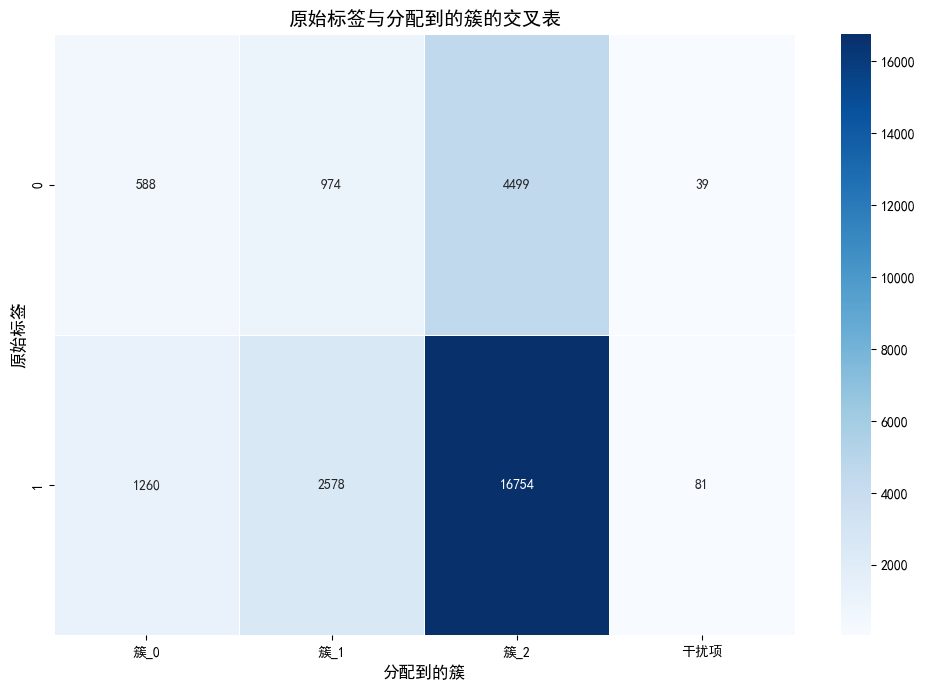

分配并还原序列:   0%|          | 0/26773 [00:00<?, ?it/s]

In [15]:

seeds=0
while(seeds<1000):
    seeds +=1000##待更改
    random.seed(seeds)
    np.random.seed(seeds)
    torch.manual_seed(seeds)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seeds)
        torch.backends.cudnn.deterministic = True # 确保 CUDA 确定性算法
    
    TOTAL_SEQUENCES = len(transformed_list) # 更新总序列数常量

    print(f"{seeds}:总共生成 {TOTAL_SEQUENCES} 条模拟序列 ({len([item for item in transformed_list if item[1] == "rand_label"])} 条干扰项)。")


    # ----------------------------------------------------------------------------
    # 运行聚类算法
    # ----------------------------------------------------------------------------

    print(f"\n--- 运行基于 RNN (预测 delta_t) 的聚类算法 (带干扰项处理) ---")
    # 修复：将 high_loss_threshold 参数名改为 high_avg_loss_threshold
    final_models, final_assignments, removed_interference_indices_final = run_rnn_clustering(
        transformed_list=transformed_list,
        num_main_models=NUM_MAIN_MODELS,
        embedding_dim=EMBEDDING_DIM,
        hidden_size=HIDDEN_SIZE,
        num_rnn_layers=NUM_RNN_LAYERS,
        num_categories=NUM_COMBINED_SETTINGS,
        time_scaler=TIME_LOSS_SCALER, # 注意：这里可能需要根据实际 delta_t 值的范围调整 scaler
        total_iterations=TOTAL_EM_ITERATIONS, # 使用更新后的迭代次数
        convergence_threshold=CONVERGENCE_THRESHOLD,
        epoch_schedule=EPOCH_SCHEDULE, # 使用更新后的 epoch 计划表
        batch_size=BATCH_SIZE,
        early_iter_batch_threshold=EARLY_ITER_BATCH_THRESHOLD, # 使用更新后的阈值
        early_iter_batch_percent=EARLY_ITER_BATCH_PERCENT,
        interference_cluster_label=INTERFERENCE_CLUSTER_LABEL, # 干扰项簇标签
        interference_detection_start_iter=INTERFERENCE_DETECTION_START_ITER, # 干扰项检测起始迭代
        high_avg_loss_threshold=HIGH_AVG_LOSS_THRESHOLD, # 高平均损失阈值
        num_rand_sequences=NUM_RAND_SEQUENCES # 已知的干扰项数量 (用于选出最高损失的 N 个)
    )

    # ----------------------------------------------------------------------------
    # 聚类结果可视化 (包含干扰项类别)
    # ----------------------------------------------------------------------------
    visualize_clustering_results(transformed_list, final_assignments, NUM_MAIN_MODELS, INTERFERENCE_CLUSTER_LABEL)
    # 初始化四个空列表，对应簇 0, 1, 2 和 3 (干扰项)
    # 这些列表将存储还原后的 [dataframe, label] 元素
    cluster_1 = [] # 对应簇 0
    cluster_2 = [] # 对应簇 1
    cluster_3 = [] # 对应簇 2
    trival_cluster = [] # 对应簇 3 (干扰项)

    # 创建一个字典，将簇索引映射到对应的列表
    cluster_map = {
        0: cluster_1,
        1: cluster_2,
        2: cluster_3,
        INTERFERENCE_CLUSTER_LABEL: trival_cluster # 使用常量
    }

    # 遍历 transformed_list 的索引
    for i in tqdm(range(len(transformed_list)), desc="分配并还原序列"):
        # 获取当前元素的分配结果
        assignment = final_assignments[i]

        # 获取当前元素的原始 transformed 格式
        transformed_element = transformed_list[i]

        # 只有分配结果在 cluster_map 的键中才进行处理
        if assignment in cluster_map:
            # 调用 restore_from_transformed_element 函数进行还原

            restored_element = restore_from_transformed_element(transformed_element)
            # 将还原后的元素添加到对应的列表中
            cluster_map[assignment].append(restored_element)
        else:
            # 处理未预期的分配值 (例如 -1, 如果聚类算法返回了未分配的序列)
            print(f"警告: 序列 {i} 具有未预期的分配值: {assignment}。原始标签: {transformed_element[1]}。还原后未分配。")
            # 这些序列不会被添加到任何 cluster_X 或 trival_cluster 列表中


In [ ]:
#不要监测代码
    INTERFERENCE_LABEL_CHECK = 'NULL'
    TARGET_LABEL_FOR_CHECK_2_3 = "'100101"

    print("--- 检查聚类条件 ---")

    # 将簇列表存储在一个方便访问的字典中
    clusters = {
        'cluster_1': cluster_1,
        'cluster_2': cluster_2,
        'cluster_3': cluster_3,
        'trival_cluster': trival_cluster
    }

    # 检查条件 1: trival_cluster 中标签为 INTERFERENCE_LABEL_CHECK 的比例最高
    print(f"\n检查条件 1: trival_cluster 中标签为 '{INTERFERENCE_LABEL_CHECK}' 的比例是否最高")
    label_proportions_interference = {}
    for name, data_list in clusters.items():
        proportion = calculate_label_proportion(data_list, INTERFERENCE_LABEL_CHECK)
        proportion_ = calculate_label_proportion(data_list, r"'000000")
        label_proportions_interference[name] = proportion
        print(f"  {name} 中标签为 '{INTERFERENCE_LABEL_CHECK}' 的比例: {proportion:.4f}")

    # 找到比例最高的簇
    max_prop_interference_cluster = max(label_proportions_interference, key=label_proportions_interference.get)
    max_prop_interference_value = label_proportions_interference[max_prop_interference_cluster]

    # 检查 trival_cluster 是否是比例最高的，且其比例严格大于其他簇
    # 需要遍历所有其他簇，确保 trival_cluster 的比例都严格大于它们
    is_trival_highest = True
    trival_prop = label_proportions_interference.get('trival_cluster', 0.0) # 如果trival_cluster为空，get返回0

    for name, prop in label_proportions_interference.items():
        if name != 'trival_cluster':
            if trival_prop <= prop: # 如果 trival_cluster 的比例不严格大于或等于其他簇的比例
                is_trival_highest = False
                break

    Bool1 = is_trival_highest
    print(f"条件 1 结果: trival_cluster ({trival_prop:.4f}) 中标签 '{INTERFERENCE_LABEL_CHECK}' 的比例是否严格高于其他簇: {Bool1}")
    # 检查条件 2: 在 cluster_1,2,3 中，setting列只有一个不为0的比例最高的簇也是标签 TARGET_LABEL_FOR_CHECK_2_3 比例最高的簇
    print(f"\n检查条件 2: 主簇中 '一个 setting 不为 0' 比例最高的簇是否也对应标签 '{TARGET_LABEL_FOR_CHECK_2_3}' 比例最高")
    main_clusters = {
        'cluster_1': cluster_1,
        'cluster_2': cluster_2,
        'cluster_3': cluster_3
    }

    one_nonzero_setting_proportions = {}
    target_label_proportions_main = {}
    for name, data_list in main_clusters.items():
        # 计算 '一个 setting 不为 0' 的行比例
        prop_one_nonzero = calculate_row_condition_proportion(data_list, is_one_setting_nonzero)
        one_nonzero_setting_proportions[name] = prop_one_nonzero
        print(f"  {name} 中 '一个 setting 不为 0' 的行比例: {prop_one_nonzero:.4f}")

        # 计算标签为 TARGET_LABEL_FOR_CHECK_2_3 的元素比例
        prop_target_label = calculate_label_proportion(data_list, TARGET_LABEL_FOR_CHECK_2_3)
        target_label_proportions_main[name] = prop_target_label
        print(f"  {name} 中标签为 '{TARGET_LABEL_FOR_CHECK_2_3}' 的元素比例: {prop_target_label:.4f}")

    # 找到 '一个 setting 不为 0' 比例最高的簇
    # 如果所有比例都为 0，max 会返回第一个键。这里我们假设在有意义的数据上运行。
    if one_nonzero_setting_proportions: # 避免在 main_clusters 都为空时出错
        max_one_nonzero_cluster = max(one_nonzero_setting_proportions, key=one_nonzero_setting_proportions.get)
        # 找到标签 TARGET_LABEL_FOR_CHECK_2_3 比例最高的簇
        max_target_label_main_cluster = max(target_label_proportions_main, key=target_label_proportions_main.get)

        # 检查两个簇是否是同一个
        Bool2 = (max_one_nonzero_cluster == max_target_label_main_cluster)
        print(f"条件 2 结果: '一个 setting 不为 0' 比例最高的簇是 {max_one_nonzero_cluster}，标签 '{TARGET_LABEL_FOR_CHECK_2_3}' 比例最高的簇是 {max_target_label_main_cluster}。它们是否一致: {Bool2}")
    else:
        Bool2 = False
        print("条件 2 结果: 主簇列表为空，无法检查条件 2。 Bool2 = False")


    # 检查条件 3: 所有簇中 setting 列取 1 或 -1 的比例最高的簇，其标签为 TARGET_LABEL_FOR_CHECK_2_3 的比例最低
    print(f"\n检查条件 3: 'setting 为 1 或 -1' 比例最高的簇是否对应标签 '{TARGET_LABEL_FOR_CHECK_2_3}' 比例最低")

    setting_1_or_neg1_proportions = {}
    target_label_proportions_all = {} # 计算所有四个簇中标签 TARGET_LABEL_FOR_CHECK_2_3 的比例

    for name, data_list in clusters.items():
        # 计算 'setting 为 1 或 -1' 的行比例
        prop_1_or_neg1 = calculate_row_condition_proportion(data_list, is_any_setting_1_or_neg1)
        setting_1_or_neg1_proportions[name] = prop_1_or_neg1
        print(f"  {name} 中 'setting 为 1 或 -1' 的行比例: {prop_1_or_neg1:.4f}")

        # 计算标签为 TARGET_LABEL_FOR_CHECK_2_3 的元素比例 (包括 trival_cluster)
        prop_target_label_all = calculate_label_proportion(data_list, TARGET_LABEL_FOR_CHECK_2_3)
        target_label_proportions_all[name] = prop_target_label_all
        print(f"  {name} 中标签为 '{TARGET_LABEL_FOR_CHECK_2_3}' 的元素比例: {prop_target_label_all:.4f}")


    # 找到 'setting 为 1 或 -1' 比例最高的簇 (在所有四个簇中)
    if setting_1_or_neg1_proportions: # 避免所有簇都为空时出错
        max_1_or_neg1_cluster = max(setting_1_or_neg1_proportions, key=setting_1_or_neg1_proportions.get)

        # 找到标签 TARGET_LABEL_FOR_CHECK_2_3 比例最低的簇 (在所有四个簇中)
        # 确保在非空列表中查找最小值
        if target_label_proportions_all:
            min_target_label_all_cluster = min(target_label_proportions_all, key=target_label_proportions_all.get)

            # 检查两个簇是否是同一个
            Bool3 = (max_1_or_neg1_cluster == min_target_label_all_cluster)
            print(f"条件 3 结果: 'setting 为 1 或 -1' 比例最高的簇是 {max_1_or_neg1_cluster}，标签 '{TARGET_LABEL_FOR_CHECK_2_3}' 比例最低的簇是 {min_target_label_all_cluster}。它们是否一致: {Bool3}")
        else:
            Bool3 = False
            print("条件 3 结果: 标签比例列表为空，无法检查条件 3。 Bool3 = False")

    else:
        Bool3 = False
        print("条件 3 结果: 'setting 为 1 或 -1' 比例列表为空，无法检查条件 3。 Bool3 = False")

    # ----------------------------------------------------------------------------
    # 输出最终的 boolean 结果
    # ----------------------------------------------------------------------------
    print("\n--- 最终检查结果 ---")
    print(f"Bool1 (trival_cluster 中 '{INTERFERENCE_LABEL_CHECK}' 比例是否最高): {Bool1}")
    print(f"Bool2 (主簇中 '一个 setting 不为 0' 比例最高的簇是否也对应标签 '{TARGET_LABEL_FOR_CHECK_2_3}' 比例最高): {Bool2}")
    print(f"Bool3 (所有簇中 'setting 为 1 或 -1' 比例最高的簇是否对应标签 '{TARGET_LABEL_FOR_CHECK_2_3}' 比例最低): {Bool3}")

    if(Bool1 and Bool2):
        print("seed={}".format(seeds))
        break


In [ ]:
model1=final_models[0]
model2=final_models[1]
model3=final_models[2]

torch.save(model1,"model1_traffic.pth")
torch.save(model2,"model2_traffic.pth")
torch.save(model3,"model3_traffic.pth")
np.save("final_assignments_traffic.npy", final_assignments)

In [16]:
len([4.528248310089111, 20.962005615234375, 23.158100128173828, 48.80531692504883, 69.26485443115234, 13.228935241699219, 84.53402709960938, 69.27651977539062, 40.80229187011719, 124.71247100830078, 117.1905517578125, 58.40407180786133, 88.42476654052734, 109.03489685058594, 75.29035949707031, 128.4618377685547, 118.35751342773438, 121.6068115234375, 1.0373468399047852, 45.46259689331055, 32.62873458862305, 67.41233825683594, 44.61530685424805, 62.269187927246094, 16.671537399291992, 13.39727783203125, 29.179975509643555, 16.70641326904297, 32.2556266784668, 8.875743865966797, 18.401681900024414, 9.210585594177246, 20.830732345581055, 93.52974700927734, 51.23618698120117, 42.92007064819336, 42.96586608886719, 26.579233169555664, 104.00607299804688, 49.98732376098633, 114.29193115234375, 103.265869140625, 82.36804962158203, 69.61848449707031, 50.73518753051758, 117.02971649169922, 80.56785583496094, 51.73518753051758, 42.10701370239258, 90.8962173461914, 107.19678497314453, 81.38452911376953, 124.66401672363281, 105.8481674194336, 94.3414077758789, 121.94876098632812, 89.14598846435547, 158.2998809814453, 53.56004333496094, 27.12193489074707, 118.24347686767578, 93.5034408569336, 70.186767578125, 116.81922912597656, 83.50789642333984, 29.583786010742188, 27.796974182128906, 25.715848922729492, 14.15487289428711, 109.6292953491211, 67.0335922241211, 63.724571228027344, 73.0933837890625, 109.26658630371094, 78.95842742919922, 98.10722351074219, 130.66796875, 60.272159576416016, 85.55057525634766, 73.14510345458984, 116.6178207397461, 106.6744613647461, 92.18941497802734, 75.1093978881836, 57.916404724121094, 102.93305206298828, 80.52803802490234, 51.95372772216797, 69.5901870727539, 55.730682373046875, 0.8323228359222412, 88.08336639404297, 98.76470947265625, 46.22500991821289, 106.69845581054688, 55.3946418762207, 59.91810989379883, 121.4029541015625, 76.3893814086914, 79.25416564941406, 50.36357498168945, 112.00352478027344, 56.8695068359375, 70.31038665771484, 122.57527923583984, 92.93172454833984, 55.394142150878906, 27.108705520629883, 45.152095794677734, 105.33924102783203, 60.08955383300781, 41.38375473022461, 31.3472843170166, 33.15084457397461, 37.22893524169922, 26.018117904663086, 83.44104766845703, 57.03584671020508, 41.44853973388672, 31.249792098999023, 24.36625099182129, 22.999393463134766, 24.870193481445312, 10.006185531616211, 75.08212280273438, 45.851993560791016, 41.41484069824219, 98.543701171875, 23.676137924194336, 84.51094818115234, 72.7696304321289, 29.772445678710938, 47.97158432006836, 37.46150588989258, 25.543521881103516, 39.113216400146484, 105.38160705566406, 76.75279235839844, 101.21226501464844, 50.04987335205078, 73.0643310546875, 113.02139282226562, 107.32344818115234, 94.02808380126953, 66.14834594726562, 114.2734603881836, 82.54296112060547, 45.03092956542969, 99.95858001708984, 103.1845932006836, 33.10469436645508, 31.848697662353516, 53.62186050415039, 52.45313262939453, 50.79163360595703, 47.46754455566406, 25.26801109313965, 82.1328125, 54.36731719970703, 38.756778717041016, 68.39028930664062, 65.39274597167969, 102.89468383789062, 92.3876953125, 19.35474395751953, 49.717281341552734, 38.62293243408203, 101.75531768798828, 43.056419372558594, 18.811309814453125, 104.11964416503906, 92.04073333740234, 110.33747863769531, 97.3042221069336, 76.26315307617188, 112.89301300048828, 75.2774887084961, 124.04625701904297, 91.27967834472656, 94.1709976196289, 104.40581512451172, 98.95223236083984, 67.7594223022461, 107.79503631591797, 76.05406951904297, 120.8322982788086, 102.3365249633789, 83.27871704101562, 57.37030792236328, 11.457587242126465, 89.03266143798828, 53.424156188964844, 110.74727630615234])

193

In [11]:
n = int(input())
for i in range(n):
        print('*'*(i+1))

*
**
***
****
